<a href="https://www.kaggle.com/code/amroaskar/titanic?scriptVersionId=137382948" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Importing the data**

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

**Discovering the data**

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.corr()

/tmp/ipykernel_20/2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


**Cleaning the data**

In [7]:
train.dropna(subset=['Embarked'], axis=0, inplace=True)
train.drop('Cabin', axis=1, inplace=True)
train.drop('Name', axis=1, inplace=True)
train.drop('Ticket', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)

In [8]:
train.index = np.arange(len(train))

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [10]:
test.drop('Cabin', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)
test['Fare'].fillna(method='ffill', inplace=True)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


**Splitting Data**

In [12]:
train['Fare_cat'] = pd.cut(train['Fare'], bins=[-np.inf, 8.0, 15.0, 31.0, np.inf], labels=[1, 2, 3, 4])

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, cv_index in split.split(train, train['Fare_cat']):
    train_data = train.loc[train_index]
    cv_data = train.loc[cv_index]

In [14]:
for _ in (train_data, cv_data):
    _.drop('Fare_cat', axis=1, inplace=True)

In [15]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived'].copy()

In [16]:
X_train_num = X_train.drop(['Sex', 'Embarked'], axis=1)
X_train_num

,Pclass,Age,SibSp,Parch,Fare
420,3,21.0,0,0,7.7333
569,2,62.0,0,0,10.5000
798,3,30.0,1,1,24.1500
246,2,24.0,0,2,14.5000
155,3,16.0,0,0,7.7333
...,...,...,...,...,...
204,3,2.0,0,1,10.4625
656,3,32.0,1,1,15.5000
702,3,25.0,0,0,7.7417
764,1,51.0,1,0,77.9583


In [17]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 420 to 100
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  711 non-null    int64  
 1   Age     572 non-null    float64
 2   SibSp   711 non-null    int64  
 3   Parch   711 non-null    int64  
 4   Fare    711 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 33.3 KB


****

**Handling test and numerical attributes**

In [18]:
num_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_train_num_tr = num_pipline.fit_transform(X_train_num)

In [19]:
num_attributes = list(X_train_num)
cat_attributes = ['Sex', 'Embarked']
full_pipline = ColumnTransformer([
    ('num', num_pipline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

In [20]:
X_train_prepared = full_pipline.fit_transform(X_train)

In [21]:
X_cv = cv_data.drop('Survived', axis=1)
y_cv = cv_data['Survived'].copy()

In [22]:
X_cv

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
279,3,male,65.0,0,0,7.7500,Q
690,3,female,4.0,0,1,13.4167,C
462,2,male,48.0,0,0,13.0000,S
720,3,male,17.0,1,0,7.0542,S
761,3,male,20.0,0,0,7.2292,C
...,...,...,...,...,...,...,...
598,1,male,49.0,1,0,56.9292,C
811,2,male,35.0,0,0,10.5000,S
221,3,male,51.0,0,0,8.0500,S
637,3,female,41.0,0,5,39.6875,S


In [23]:
X_cv_prepared = full_pipline.fit_transform(X_cv)

**LogisticRegression model**

In [24]:
log = LogisticRegression()
log.fit(X_train_prepared, y_train)

LogisticRegression()

In [25]:
train_predict = log.predict(X_train_prepared)
accuracy_score(y_train, train_predict)

0.810126582278481

In [26]:
np.mean(cross_val_score(log, X_train_prepared, y_train, cv=5, scoring='accuracy'))

0.8087855806165664

0.7866316947288264

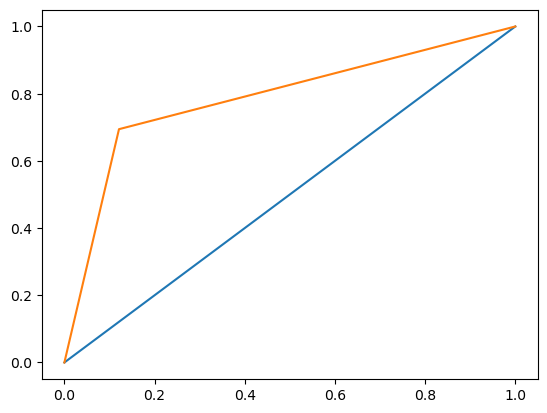

In [27]:
fpr, tpr, thresholds = roc_curve(y_train, train_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_train, train_predict)

In [28]:
cv_predict = log.predict(X_cv_prepared)
accuracy_score(y_cv, cv_predict)

0.7696629213483146

In [29]:
np.mean(cross_val_score(log, X_cv_prepared, y_cv, cv=5, scoring='accuracy'))

0.77

0.7574757281553398

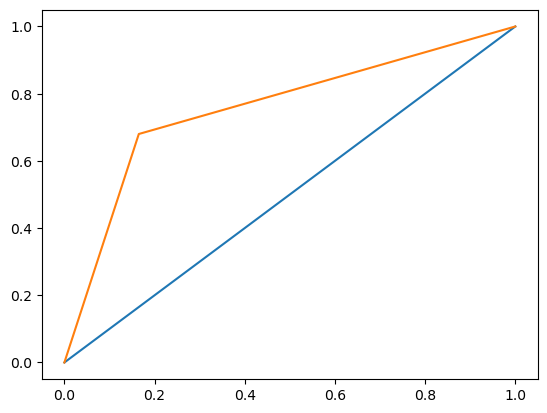

In [30]:
fpr, tpr, thresholds = roc_curve(y_cv, cv_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_cv, cv_predict)

**KNeighborsClassifier model**

In [31]:
param_grid = [
    {'n_neighbors':np.arange(1, 10)}
]
neighbor = KNeighborsClassifier()
grid_search = GridSearchCV(neighbor, cv=5, param_grid=param_grid, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             return_train_score=True, scoring='accuracy')

In [32]:
neighbor = grid_search.best_estimator_

In [33]:
train_predict = neighbor.predict(X_train_prepared)

In [34]:
accuracy_score(y_train, train_predict)

0.8762306610407876

In [35]:
np.mean(cross_val_score(neighbor, X_train_prepared, y_train, cv=5, scoring='accuracy'))

0.8088052792278144

0.8615280480582114

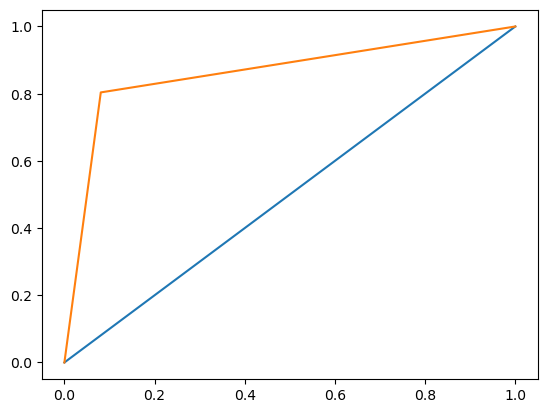

In [36]:
fpr, tpr, thresholds = roc_curve(y_train, train_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_train, train_predict)

In [37]:
cv_predict = neighbor.predict(X_cv_prepared)

In [38]:
accuracy_score(y_cv, cv_predict)

0.7752808988764045

In [39]:
np.mean(cross_val_score(neighbor, X_cv_prepared, y_cv, cv=5, scoring='accuracy'))

0.7241269841269842

0.7550809061488674

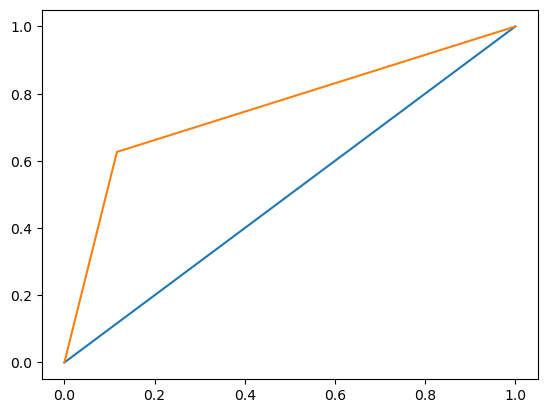

In [40]:
fpr, tpr, thresholds = roc_curve(y_cv, cv_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_cv, cv_predict)

**RandomForestClassifier model**

In [41]:
param_grid = [
{'n_estimators': [4, 5], 'max_features': [2, 4]},
{'bootstrap': [False], 'n_estimators': [3, 8], 'max_features': [2, 3, 4]},
]
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4], 'n_estimators': [4, 5]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 8]}],
             return_train_score=True, scoring='accuracy')

In [42]:
forest = grid_search.best_estimator_
train_predict = forest.predict(X_train_prepared)

In [43]:
accuracy_score(y_train, train_predict)

0.9535864978902954

In [44]:
np.mean(cross_val_score(forest, X_train_prepared, y_train, cv=5, scoring='accuracy'))

0.7849108637841031

0.9469244436923598

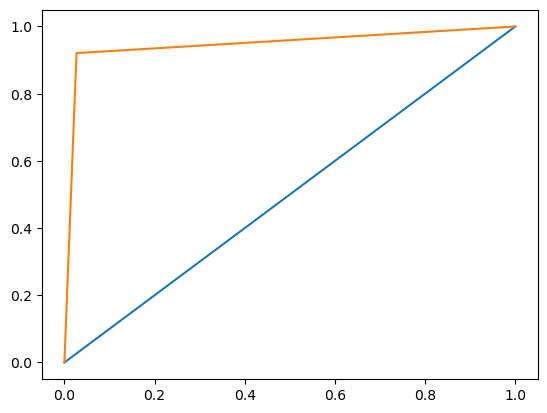

In [45]:
fpr, tpr, thresholds = roc_curve(y_train, train_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_train, train_predict)

In [46]:
cv_predict = forest.predict(X_cv_prepared)
accuracy_score(y_cv, cv_predict)

0.8033707865168539

In [47]:
np.mean(cross_val_score(forest, X_cv_prepared, y_cv, cv=5, scoring='accuracy'))

0.758095238095238

0.795663430420712

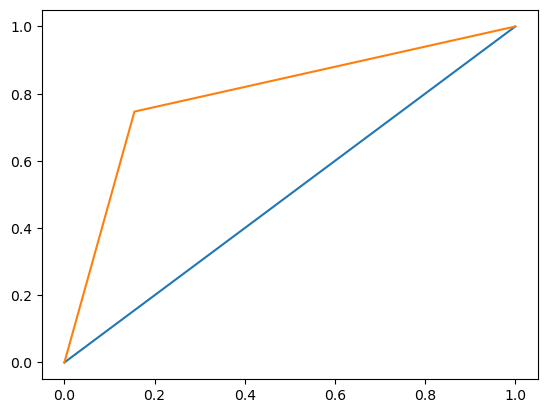

In [48]:
fpr, tpr, thresholds = roc_curve(y_cv, cv_predict)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
roc_auc_score(y_cv, cv_predict)

**Final model**

In [49]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S
414,1306,1,female,39.0,0,0,108.9000,C
415,1307,3,male,38.5,0,0,7.2500,S
416,1308,3,male,NaN,0,0,8.0500,S


In [50]:
submission = pd.DataFrame()
submission.index = test['PassengerId']

In [51]:
test.drop('PassengerId', axis=1, inplace=True)

In [52]:
test_prepared = full_pipline.fit_transform(test)

In [53]:
submission['Survived'] = log.predict(test_prepared)

In [54]:
submission.to_csv('submission.csv')